In [1]:
 #mounting to google drive for file

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:

# check if the zip file is here
!ls /content/drive/MyDrive/Colab\ Notebooks/


'archive (4).zip'			     'CNN_(3) (1).ipynb'  'Untitled (3)'
'CNN_(3)_(1)_(1)_(1)_(1)_(1)_(2) (4).ipynb'  'CNN_(3)_(1).ipynb'  'Untitled (4)'
'CNN_(3)_(1)_(1)_(1)_(1)_(1) (2).ipynb'      'CNN final.ipynb'	  'Untitled (5)'
'CNN_(3)_(1)_(1)_(1) (1) (1).ipynb'	     'Copy of CNN.ipynb'  'Untitled (6)'
'CNN_(3)_(1)_(1)_(1)_(1) (1).ipynb'	      hillclimbing.ipynb  'Untitled (7)'
'CNN_(3)_(1)_(1)_(1)_(1) (2).ipynb'	      idlmam.py		  'Untitled (8)'
'CNN_(3)_(1)_(1)_(1)_(1) (3).ipynb'	      __pycache__	  'Week01_IntroToPyTorch (1).ipynb'
'CNN_(3)_(1)_(1)_(1) (1).ipynb'		      RNN.ipynb		   Week01_IntroToPyTorch.ipynb
'CNN_(3)_(1)_(1)_(1)_(1).ipynb'		      Untitled		   Week02_Exercises.ipynb
'CNN_(3)_(1)_(1) (1).ipynb'		     'Untitled (1)'	   Week02_PyTorchII.ipynb
'CNN_(3)_(1)_(1).ipynb'			     'Untitled (2)'	   Week07_CNN_II_Exercise.ipynb


In [3]:

#unzip the file
!unzip "/content/drive/MyDrive/Colab Notebooks/archive (4).zip" -d "/content/asl_dataset"


Streaming output truncated to the last 5000 lines.
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2863).jpg  
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2864).jpg  
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2865).jpg  
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2866).jpg  
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2867).jpg  
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2868).jpg  
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2869).jpg  
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (287).jpg  
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2870).jpg  
  inflating: /content/asl_dataset/ASL_Alphabet_Dataset/asl_

In [4]:
#check what is inside the file
!ls /content/asl_dataset


ASL_Alphabet_Dataset


In [5]:

#imports
import torchvision
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.utils.data import DataLoader,Subset,random_split
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score,precision_score, recall_score,confusion_matrix, ConfusionMatrixDisplay
from torchvision.utils import make_grid
import torch.optim as optim
from torch.optim import SGD
import random
import os
import shutil


In [6]:
# check training directory
!ls /content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train



A  B  C  D  del  E  F  G  H  I	J  K  L  M  N  nothing	O  P  Q  R  S  space  T  U  V  W  X  Y	Z


In [7]:
# Check for CUDA device
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [8]:
#reesize to 64x64 and normalize to [1,-1]
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# load the dataset
dataset = datasets.ImageFolder('/content/asl_dataset/ASL_Alphabet_Dataset/asl_alphabet_train', transform=transform)

#20% training dataset which is like 44614 and 6% validation which is 13384 enought data so do not need to augment.It is to make sure that the training does not take too long
train_percentage = 0.2
val_percentage = 0.06
train_size = int(train_percentage * len(dataset))
val_size = int(val_percentage * len(dataset))
unused_size = len(dataset) - train_size - val_size
# train_subset is 20% val_dataset is 6% _ unused data
train_subset, val_dataset, _ = random_split(dataset, [train_size, val_size, unused_size])

# dataloader
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
print(f"Training dataset size: {len(train_subset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Training dataset size: 44614
Validation dataset size: 13384


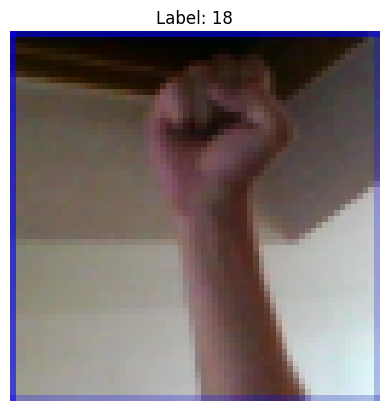

In [9]:
#convert train loader into a iterator which allows us to manually retrive a 1 single batch
data_iter = iter(train_loader)
images, labels = next(data_iter)

# unnormalize the first image back to [0, 1] becuase normalized image pixel values are not suitable for direct visualization.
image = images[0] * 0.5 + 0.5
image = image.numpy().transpose((1, 2, 0))
# Plot the image
plt.imshow(image)
plt.title(f"Label: {labels[0]}")
plt.axis("off")
plt.show()

In [13]:
class ASLCNN(nn.Module):
    def __init__(self, num_classes=29):
        super(ASLCNN, self).__init__()

        # 3 layers kernal size 3 stride and padding 1 with max pooling and dropout set to 0.2 becuase 0.5 is too much
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

        # fully connected layer for classification,
        self.flattened_size = None
        self.fc1 = None #512 neurons
        self.fc2 = nn.Linear(512, num_classes) #29 neurons num of classes

    #define how the model should run accordingly
    def forward(self, x):
        x = self.relu((self.conv1(x)))  # convolution -> normalization -> ReLU
        x = self.pool(x)
        x = self.relu((self.conv2(x)))
        x = self.pool(x)
        x = self.relu((self.conv3(x)))
        x = self.pool(x)
        # dynamically compute flattened size
        if self.flattened_size is None:
            self.flattened_size = x.view(x.size(0), -1).size(1)
            self.fc1 = nn.Linear(self.flattened_size, 512).to(x.device)

        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))  # fully connected layer
        x = self.dropout(x)  # dropout for regularization
        x = self.fc2(x)  # output layer
        return x


In [ ]:

def train_with_optimizer(optimizer_name, optimizer_class, model, train_loader, num_epochs=20, **optimizer_params):
    print(f"\nTraining with {optimizer_name} optimizer...")
    model = ASLCNN(num_classes=29).to(device)
    optimizer = optimizer_class(model.parameters(), **optimizer_params)
    #loss function
    loss_func = nn.CrossEntropyLoss()
    model.train()
    # loss and accuracy
    loss_history = []
    accuracy_history = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        #progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch")
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # forward pass:  predictions
            outputs = model(inputs)
            loss = loss_func(outputs, labels)  #  loss

            # backward pass: reset gradients, compute new gradients, and update model weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            # calculate the number of correct predictions in the batch
            _, predicted = outputs.max(1)  # get class with max probability
            total += labels.size(0)  # total number of samples
            correct += predicted.eq(labels).sum().item()  # count correct predictions
            progress_bar.set_postfix(loss=(running_loss / len(train_loader)))

        # calculate average loss and accuracy for the epoch
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct / total

        loss_history.append(epoch_loss)
        accuracy_history.append(epoch_accuracy)
        print(f"Epoch {epoch + 1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_accuracy:.4f}")

    # return the loss and accuracy
    return loss_history, accuracy_history




i want to see which optimizer gives me the best accuracy with the lowest noise so that i can apply the best optimizer for this

Stocastic gradient descent

In [ ]:
optimizer_name = "SGD"
optimizer_class = SGD
params = {"lr": 0.01}
batch_size = 1  # SGD uses batch size 1
num_samples_per_epoch = 1000  # random samples to process in each epoch
loss_history = []
accuracy_history = []


model = ASLCNN(num_classes=29)
for epoch in range(20):  #20 epoch
    # Randomly sample for each epoch
    random_indices = random.sample(range(len(train_subset)), num_samples_per_epoch)
    sampled_subset = Subset(train_subset, random_indices)
    optimizer_train_loader = DataLoader(sampled_subset, batch_size=batch_size, shuffle=True)
    epoch_loss_history, epoch_accuracy_history = train_with_optimizer(
        optimizer_name, optimizer_class, model, optimizer_train_loader, num_epochs=1, **params
    )


    loss_history.extend(epoch_loss_history)
    accuracy_history.extend(epoch_accuracy_history)


results_sgd = {"loss": loss_history, "accuracy": accuracy_history}



Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:10<00:00, 97.93batch/s, loss=3.37]


Epoch 1: Loss = 3.3655, Accuracy = 0.0660

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:08<00:00, 117.19batch/s, loss=3.33]


Epoch 1: Loss = 3.3298, Accuracy = 0.0800

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:08<00:00, 111.38batch/s, loss=3.36]


Epoch 1: Loss = 3.3642, Accuracy = 0.0580

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:08<00:00, 119.95batch/s, loss=3.34]


Epoch 1: Loss = 3.3410, Accuracy = 0.0630

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:08<00:00, 111.69batch/s, loss=3.35]


Epoch 1: Loss = 3.3519, Accuracy = 0.0730

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:08<00:00, 117.38batch/s, loss=3.36]


Epoch 1: Loss = 3.3616, Accuracy = 0.0650

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:08<00:00, 117.05batch/s, loss=3.33]


Epoch 1: Loss = 3.3345, Accuracy = 0.0730

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:09<00:00, 108.23batch/s, loss=3.35]


Epoch 1: Loss = 3.3533, Accuracy = 0.0700

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:08<00:00, 123.94batch/s, loss=3.35]


Epoch 1: Loss = 3.3538, Accuracy = 0.0640

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:09<00:00, 108.07batch/s, loss=3.31]


Epoch 1: Loss = 3.3115, Accuracy = 0.0830

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:08<00:00, 116.07batch/s, loss=3.34]


Epoch 1: Loss = 3.3438, Accuracy = 0.0590

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:08<00:00, 118.26batch/s, loss=3.35]


Epoch 1: Loss = 3.3456, Accuracy = 0.0750

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:09<00:00, 109.38batch/s, loss=3.32]


Epoch 1: Loss = 3.3236, Accuracy = 0.0650

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:08<00:00, 123.87batch/s, loss=3.32]


Epoch 1: Loss = 3.3210, Accuracy = 0.0730

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:08<00:00, 111.81batch/s, loss=3.35]


Epoch 1: Loss = 3.3521, Accuracy = 0.0690

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:08<00:00, 119.12batch/s, loss=3.34]


Epoch 1: Loss = 3.3380, Accuracy = 0.0610

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:08<00:00, 113.44batch/s, loss=3.34]


Epoch 1: Loss = 3.3399, Accuracy = 0.0780

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:09<00:00, 108.42batch/s, loss=3.33]


Epoch 1: Loss = 3.3336, Accuracy = 0.0740

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:07<00:00, 126.33batch/s, loss=3.37]


Epoch 1: Loss = 3.3654, Accuracy = 0.0680

Training with SGD optimizer...


Epoch 1/1: 100%|██████████| 1000/1000 [00:08<00:00, 112.35batch/s, loss=3.36]

Epoch 1: Loss = 3.3568, Accuracy = 0.0700


mini batch gradient descent

In [ ]:
optimizer_name = "Mini-batch Gradient Descent (MBGD)"
optimizer_class = SGD
params = {"lr": 0.01}
batch_size = 64  # bigger batch size becuase train in small groups


optimizer_train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
loss_history, accuracy_history = train_with_optimizer(
    optimizer_name, optimizer_class, ASLCNN(num_classes=29), optimizer_train_loader, num_epochs=20, **params
)


results_mbgd = {"loss": loss_history, "accuracy": accuracy_history}



Training with Mini-batch Gradient Descent (MBGD) optimizer...


Epoch 1/20: 100%|██████████| 698/698 [01:50<00:00,  6.33batch/s, loss=3.04]


Epoch 1: Loss = 3.0369, Accuracy = 0.1847


Epoch 2/20: 100%|██████████| 698/698 [01:29<00:00,  7.81batch/s, loss=2.37]


Epoch 2: Loss = 2.3706, Accuracy = 0.3892


Epoch 3/20: 100%|██████████| 698/698 [01:28<00:00,  7.86batch/s, loss=1.88]


Epoch 3: Loss = 1.8818, Accuracy = 0.5144


Epoch 4/20: 100%|██████████| 698/698 [01:30<00:00,  7.71batch/s, loss=1.56]


Epoch 4: Loss = 1.5557, Accuracy = 0.5965


Epoch 5/20: 100%|██████████| 698/698 [01:29<00:00,  7.83batch/s, loss=1.33]


Epoch 5: Loss = 1.3259, Accuracy = 0.6591


Epoch 6/20: 100%|██████████| 698/698 [01:28<00:00,  7.85batch/s, loss=1.16]


Epoch 6: Loss = 1.1578, Accuracy = 0.6996


Epoch 7/20: 100%|██████████| 698/698 [01:29<00:00,  7.79batch/s, loss=1.02]


Epoch 7: Loss = 1.0219, Accuracy = 0.7394


Epoch 8/20: 100%|██████████| 698/698 [01:27<00:00,  7.94batch/s, loss=0.915]


Epoch 8: Loss = 0.9153, Accuracy = 0.7660


Epoch 9/20: 100%|██████████| 698/698 [01:28<00:00,  7.92batch/s, loss=0.826]


Epoch 9: Loss = 0.8258, Accuracy = 0.7903


Epoch 10/20: 100%|██████████| 698/698 [01:29<00:00,  7.78batch/s, loss=0.751]


Epoch 10: Loss = 0.7507, Accuracy = 0.8082


Epoch 11/20: 100%|██████████| 698/698 [01:28<00:00,  7.86batch/s, loss=0.684]


Epoch 11: Loss = 0.6844, Accuracy = 0.8273


Epoch 12/20: 100%|██████████| 698/698 [01:28<00:00,  7.87batch/s, loss=0.633]


Epoch 12: Loss = 0.6329, Accuracy = 0.8408


Epoch 13/20: 100%|██████████| 698/698 [01:29<00:00,  7.83batch/s, loss=0.579]


Epoch 13: Loss = 0.5794, Accuracy = 0.8553


Epoch 14/20: 100%|██████████| 698/698 [01:29<00:00,  7.81batch/s, loss=0.542]


Epoch 14: Loss = 0.5424, Accuracy = 0.8659


Epoch 15/20: 100%|██████████| 698/698 [01:28<00:00,  7.88batch/s, loss=0.505]


Epoch 15: Loss = 0.5053, Accuracy = 0.8732


Epoch 16/20: 100%|██████████| 698/698 [01:29<00:00,  7.84batch/s, loss=0.476]


Epoch 16: Loss = 0.4761, Accuracy = 0.8808


Epoch 17/20: 100%|██████████| 698/698 [01:30<00:00,  7.75batch/s, loss=0.446]


Epoch 17: Loss = 0.4463, Accuracy = 0.8895


Epoch 18/20: 100%|██████████| 698/698 [01:28<00:00,  7.87batch/s, loss=0.414]


Epoch 18: Loss = 0.4138, Accuracy = 0.8968


Epoch 19/20: 100%|██████████| 698/698 [01:28<00:00,  7.87batch/s, loss=0.388]


Epoch 19: Loss = 0.3880, Accuracy = 0.9056


Epoch 20/20: 100%|██████████| 698/698 [01:28<00:00,  7.88batch/s, loss=0.367]

Epoch 20: Loss = 0.3674, Accuracy = 0.9111


gradient descent cant be run as the processing of the entire dataset exceeds the memory capacity of the GPU

In [ ]:
optimizer_name = "Adam"
optimizer_class = optim.Adam
params = {"lr": 0.01}
batch_size = 64


optimizer_train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
loss_history, accuracy_history = train_with_optimizer(
    optimizer_name, optimizer_class, ASLCNN(num_classes=29), optimizer_train_loader, num_epochs=20, **params
)
results_adam = {"loss": loss_history, "accuracy": accuracy_history}



Training with Adam optimizer...


Epoch 1/20: 100%|██████████| 698/698 [01:35<00:00,  7.34batch/s, loss=1.78]


Epoch 1: Loss = 1.7762, Accuracy = 0.4708


Epoch 2/20: 100%|██████████| 698/698 [01:28<00:00,  7.90batch/s, loss=0.891]


Epoch 2: Loss = 0.8911, Accuracy = 0.7254


Epoch 3/20: 100%|██████████| 698/698 [01:30<00:00,  7.70batch/s, loss=0.632]


Epoch 3: Loss = 0.6324, Accuracy = 0.8021


Epoch 4/20: 100%|██████████| 698/698 [01:29<00:00,  7.76batch/s, loss=0.506]


Epoch 4: Loss = 0.5056, Accuracy = 0.8420


Epoch 5/20: 100%|██████████| 698/698 [01:29<00:00,  7.78batch/s, loss=0.418]


Epoch 5: Loss = 0.4177, Accuracy = 0.8673


Epoch 6/20: 100%|██████████| 698/698 [01:28<00:00,  7.90batch/s, loss=0.363]


Epoch 6: Loss = 0.3634, Accuracy = 0.8846


Epoch 7/20: 100%|██████████| 698/698 [01:29<00:00,  7.84batch/s, loss=0.332]


Epoch 7: Loss = 0.3323, Accuracy = 0.8947


Epoch 8/20: 100%|██████████| 698/698 [01:28<00:00,  7.88batch/s, loss=0.288]


Epoch 8: Loss = 0.2884, Accuracy = 0.9074


Epoch 9/20: 100%|██████████| 698/698 [01:28<00:00,  7.91batch/s, loss=0.272]


Epoch 9: Loss = 0.2724, Accuracy = 0.9140


Epoch 10/20: 100%|██████████| 698/698 [01:29<00:00,  7.82batch/s, loss=0.255]


Epoch 10: Loss = 0.2551, Accuracy = 0.9180


Epoch 11/20: 100%|██████████| 698/698 [01:29<00:00,  7.76batch/s, loss=0.222]


Epoch 11: Loss = 0.2218, Accuracy = 0.9282


Epoch 12/20: 100%|██████████| 698/698 [01:28<00:00,  7.89batch/s, loss=0.213]


Epoch 12: Loss = 0.2128, Accuracy = 0.9311


Epoch 13/20: 100%|██████████| 698/698 [01:28<00:00,  7.90batch/s, loss=0.204]


Epoch 13: Loss = 0.2040, Accuracy = 0.9347


Epoch 14/20: 100%|██████████| 698/698 [01:28<00:00,  7.87batch/s, loss=0.19]


Epoch 14: Loss = 0.1901, Accuracy = 0.9381


Epoch 15/20: 100%|██████████| 698/698 [01:28<00:00,  7.87batch/s, loss=0.188]


Epoch 15: Loss = 0.1883, Accuracy = 0.9384


Epoch 16/20: 100%|██████████| 698/698 [01:28<00:00,  7.89batch/s, loss=0.169]


Epoch 16: Loss = 0.1692, Accuracy = 0.9447


Epoch 17/20: 100%|██████████| 698/698 [01:28<00:00,  7.92batch/s, loss=0.171]


Epoch 17: Loss = 0.1710, Accuracy = 0.9443


Epoch 18/20: 100%|██████████| 698/698 [01:28<00:00,  7.89batch/s, loss=0.168]


Epoch 18: Loss = 0.1682, Accuracy = 0.9455


Epoch 19/20: 100%|██████████| 698/698 [01:29<00:00,  7.80batch/s, loss=0.165]


Epoch 19: Loss = 0.1648, Accuracy = 0.9451


Epoch 20/20: 100%|██████████| 698/698 [01:28<00:00,  7.92batch/s, loss=0.139]

Epoch 20: Loss = 0.1390, Accuracy = 0.9548


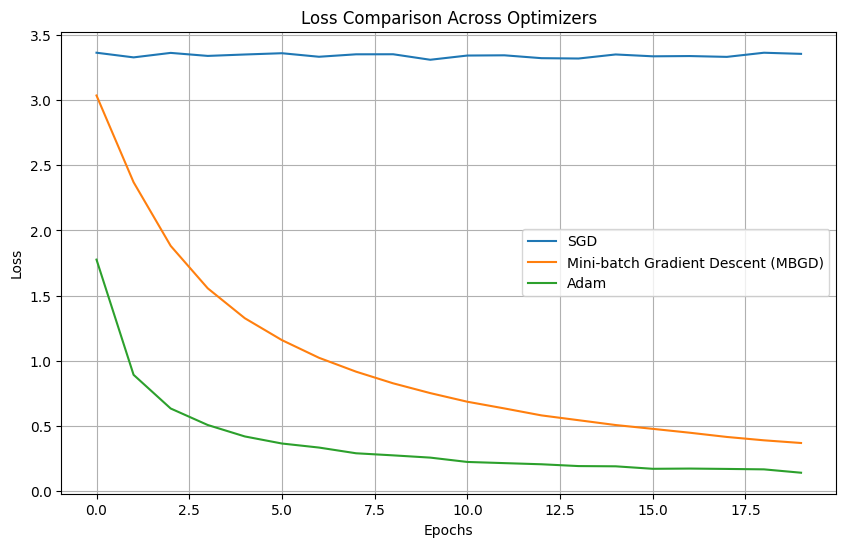

In [ ]:
# Plot the loss
results = {
    "SGD": results_sgd,
    "Mini-batch Gradient Descent (MBGD)": results_mbgd,
    "Adam": results_adam
}

plt.figure(figsize=(10, 6))
for optimizer_name, result in results.items():
    plt.plot(result["loss"], label=optimizer_name)

plt.title('Loss Comparison Across Optimizers')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

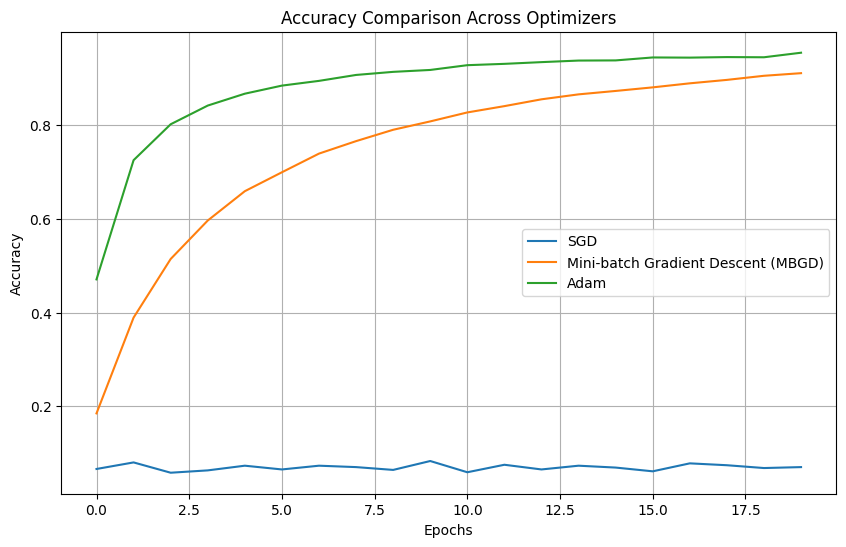

In [ ]:
# Plot the accuracy
plt.figure(figsize=(10, 6))

for optimizer_name, result in results.items():
    plt.plot(result["accuracy"], label=optimizer_name)

plt.title('Accuracy Comparison Across Optimizers')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

the accuracy shows that adam is the most accurate among the 3 algorithm  and also has the least loss meaning that it is closest to the actual values as compared to the rest

since now we know that adam is the best in terms of accuracy and loss we now have to tune the learning rate and decide which is the best for adam and make sure to prevent overfitting and underfitting

In [ ]:
#compare the different  lr to see which the best
def train_with_learning_rates(model_class, train_loader, num_epochs, learning_rates, device):
    results = {}

    for lr in learning_rates:
        print(f"\nTraining with Adam optimizer and learning rate = {lr}...")
        model = model_class(num_classes=29).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        loss_func = nn.CrossEntropyLoss()

        model.train()
        loss_history = []
        accuracy_history = []

        for epoch in range(num_epochs):
            running_loss = 0.0
            correct = 0
            total = 0
            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch")

            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = loss_func(outputs, labels)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Track metrics
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                progress_bar.set_postfix(loss=(running_loss / len(train_loader)))

            epoch_loss = running_loss / len(train_loader)
            epoch_accuracy = correct / total
            loss_history.append(epoch_loss)
            accuracy_history.append(epoch_accuracy)

            print(f"Learning Rate {lr} - Epoch {epoch + 1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_accuracy:.4f}")

        # Save the history for this learning rate
        results[lr] = {"loss": loss_history, "accuracy": accuracy_history}

    return results


In [ ]:
learning_rates = [0.01, 0.001]  # cannot have too many as it takes too long to train
num_epochs = 20

results_adam_lr = train_with_learning_rates(
    ASLCNN,
    train_loader,
    num_epochs,
    learning_rates,
    device
)



Training with Adam optimizer and learning rate = 0.01...


Epoch 1/20: 100%|██████████| 698/698 [01:30<00:00,  7.68batch/s, loss=1.79]


Learning Rate 0.01 - Epoch 1: Loss = 1.7881, Accuracy = 0.4712


Epoch 2/20: 100%|██████████| 698/698 [01:29<00:00,  7.83batch/s, loss=0.864]


Learning Rate 0.01 - Epoch 2: Loss = 0.8635, Accuracy = 0.7358


Epoch 3/20: 100%|██████████| 698/698 [01:28<00:00,  7.86batch/s, loss=0.608]


Learning Rate 0.01 - Epoch 3: Loss = 0.6081, Accuracy = 0.8120


Epoch 4/20: 100%|██████████| 698/698 [01:28<00:00,  7.88batch/s, loss=0.484]


Learning Rate 0.01 - Epoch 4: Loss = 0.4837, Accuracy = 0.8477


Epoch 5/20: 100%|██████████| 698/698 [01:28<00:00,  7.87batch/s, loss=0.411]


Learning Rate 0.01 - Epoch 5: Loss = 0.4110, Accuracy = 0.8705


Epoch 6/20: 100%|██████████| 698/698 [01:29<00:00,  7.81batch/s, loss=0.344]


Learning Rate 0.01 - Epoch 6: Loss = 0.3443, Accuracy = 0.8909


Epoch 7/20: 100%|██████████| 698/698 [01:28<00:00,  7.92batch/s, loss=0.311]


Learning Rate 0.01 - Epoch 7: Loss = 0.3106, Accuracy = 0.8999


Epoch 8/20: 100%|██████████| 698/698 [01:27<00:00,  7.95batch/s, loss=0.28]


Learning Rate 0.01 - Epoch 8: Loss = 0.2798, Accuracy = 0.9096


Epoch 9/20: 100%|██████████| 698/698 [01:28<00:00,  7.91batch/s, loss=0.253]


Learning Rate 0.01 - Epoch 9: Loss = 0.2533, Accuracy = 0.9183


Epoch 10/20: 100%|██████████| 698/698 [01:28<00:00,  7.87batch/s, loss=0.244]


Learning Rate 0.01 - Epoch 10: Loss = 0.2445, Accuracy = 0.9213


Epoch 11/20: 100%|██████████| 698/698 [01:27<00:00,  7.94batch/s, loss=0.219]


Learning Rate 0.01 - Epoch 11: Loss = 0.2193, Accuracy = 0.9287


Epoch 12/20: 100%|██████████| 698/698 [01:27<00:00,  7.98batch/s, loss=0.211]


Learning Rate 0.01 - Epoch 12: Loss = 0.2107, Accuracy = 0.9310


Epoch 13/20: 100%|██████████| 698/698 [01:28<00:00,  7.91batch/s, loss=0.192]


Learning Rate 0.01 - Epoch 13: Loss = 0.1918, Accuracy = 0.9386


Epoch 14/20: 100%|██████████| 698/698 [01:29<00:00,  7.82batch/s, loss=0.197]


Learning Rate 0.01 - Epoch 14: Loss = 0.1966, Accuracy = 0.9366


Epoch 15/20: 100%|██████████| 698/698 [01:28<00:00,  7.85batch/s, loss=0.178]


Learning Rate 0.01 - Epoch 15: Loss = 0.1777, Accuracy = 0.9426


Epoch 16/20: 100%|██████████| 698/698 [01:28<00:00,  7.91batch/s, loss=0.162]


Learning Rate 0.01 - Epoch 16: Loss = 0.1625, Accuracy = 0.9467


Epoch 17/20: 100%|██████████| 698/698 [01:27<00:00,  7.95batch/s, loss=0.162]


Learning Rate 0.01 - Epoch 17: Loss = 0.1618, Accuracy = 0.9477


Epoch 18/20: 100%|██████████| 698/698 [01:28<00:00,  7.92batch/s, loss=0.162]


Learning Rate 0.01 - Epoch 18: Loss = 0.1619, Accuracy = 0.9474


Epoch 19/20: 100%|██████████| 698/698 [01:28<00:00,  7.85batch/s, loss=0.15]


Learning Rate 0.01 - Epoch 19: Loss = 0.1499, Accuracy = 0.9510


Epoch 20/20: 100%|██████████| 698/698 [01:28<00:00,  7.90batch/s, loss=0.137]


Learning Rate 0.01 - Epoch 20: Loss = 0.1373, Accuracy = 0.9543

Training with Adam optimizer and learning rate = 0.001...


Epoch 1/20: 100%|██████████| 698/698 [01:28<00:00,  7.87batch/s, loss=1.87]


Learning Rate 0.001 - Epoch 1: Loss = 1.8683, Accuracy = 0.4757


Epoch 2/20: 100%|██████████| 698/698 [01:28<00:00,  7.93batch/s, loss=0.863]


Learning Rate 0.001 - Epoch 2: Loss = 0.8632, Accuracy = 0.7536


Epoch 3/20: 100%|██████████| 698/698 [01:30<00:00,  7.73batch/s, loss=0.568]


Learning Rate 0.001 - Epoch 3: Loss = 0.5677, Accuracy = 0.8358


Epoch 4/20: 100%|██████████| 698/698 [01:28<00:00,  7.88batch/s, loss=0.426]


Learning Rate 0.001 - Epoch 4: Loss = 0.4264, Accuracy = 0.8762


Epoch 5/20: 100%|██████████| 698/698 [01:28<00:00,  7.86batch/s, loss=0.335]


Learning Rate 0.001 - Epoch 5: Loss = 0.3352, Accuracy = 0.9013


Epoch 6/20: 100%|██████████| 698/698 [01:29<00:00,  7.82batch/s, loss=0.286]


Learning Rate 0.001 - Epoch 6: Loss = 0.2857, Accuracy = 0.9171


Epoch 7/20: 100%|██████████| 698/698 [01:29<00:00,  7.83batch/s, loss=0.244]


Learning Rate 0.001 - Epoch 7: Loss = 0.2436, Accuracy = 0.9273


Epoch 8/20: 100%|██████████| 698/698 [01:28<00:00,  7.88batch/s, loss=0.211]


Learning Rate 0.001 - Epoch 8: Loss = 0.2114, Accuracy = 0.9372


Epoch 9/20: 100%|██████████| 698/698 [01:28<00:00,  7.91batch/s, loss=0.188]


Learning Rate 0.001 - Epoch 9: Loss = 0.1882, Accuracy = 0.9430


Epoch 10/20: 100%|██████████| 698/698 [01:28<00:00,  7.89batch/s, loss=0.168]


Learning Rate 0.001 - Epoch 10: Loss = 0.1676, Accuracy = 0.9485


Epoch 11/20: 100%|██████████| 698/698 [01:29<00:00,  7.77batch/s, loss=0.147]


Learning Rate 0.001 - Epoch 11: Loss = 0.1466, Accuracy = 0.9554


Epoch 12/20: 100%|██████████| 698/698 [01:29<00:00,  7.84batch/s, loss=0.146]


Learning Rate 0.001 - Epoch 12: Loss = 0.1461, Accuracy = 0.9542


Epoch 13/20: 100%|██████████| 698/698 [01:29<00:00,  7.82batch/s, loss=0.126]


Learning Rate 0.001 - Epoch 13: Loss = 0.1259, Accuracy = 0.9607


Epoch 14/20: 100%|██████████| 698/698 [01:30<00:00,  7.68batch/s, loss=0.121]


Learning Rate 0.001 - Epoch 14: Loss = 0.1212, Accuracy = 0.9617


Epoch 15/20: 100%|██████████| 698/698 [01:30<00:00,  7.75batch/s, loss=0.111]


Learning Rate 0.001 - Epoch 15: Loss = 0.1115, Accuracy = 0.9652


Epoch 16/20: 100%|██████████| 698/698 [01:29<00:00,  7.76batch/s, loss=0.107]


Learning Rate 0.001 - Epoch 16: Loss = 0.1067, Accuracy = 0.9668


Epoch 17/20: 100%|██████████| 698/698 [01:30<00:00,  7.69batch/s, loss=0.104]


Learning Rate 0.001 - Epoch 17: Loss = 0.1042, Accuracy = 0.9679


Epoch 18/20: 100%|██████████| 698/698 [01:29<00:00,  7.78batch/s, loss=0.0975]


Learning Rate 0.001 - Epoch 18: Loss = 0.0975, Accuracy = 0.9685


Epoch 19/20: 100%|██████████| 698/698 [01:29<00:00,  7.76batch/s, loss=0.0886]


Learning Rate 0.001 - Epoch 19: Loss = 0.0886, Accuracy = 0.9728


Epoch 20/20: 100%|██████████| 698/698 [01:31<00:00,  7.65batch/s, loss=0.1]

Learning Rate 0.001 - Epoch 20: Loss = 0.1004, Accuracy = 0.9687


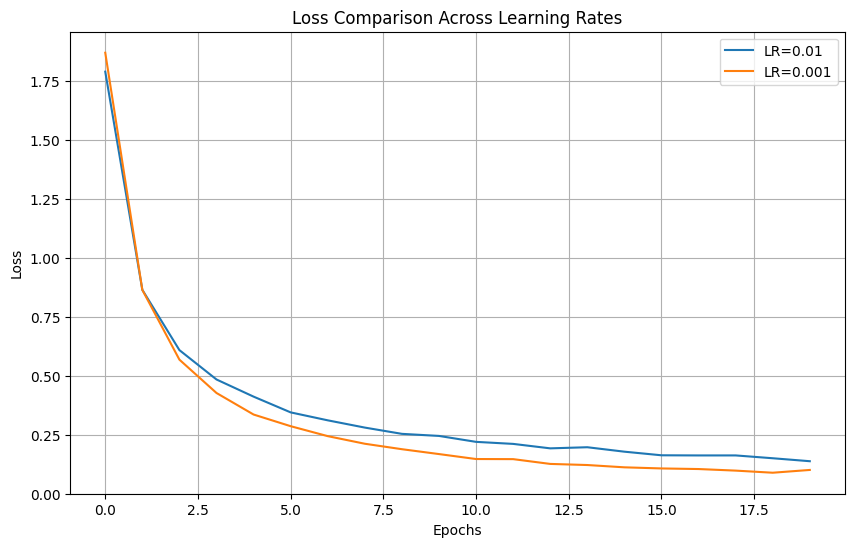

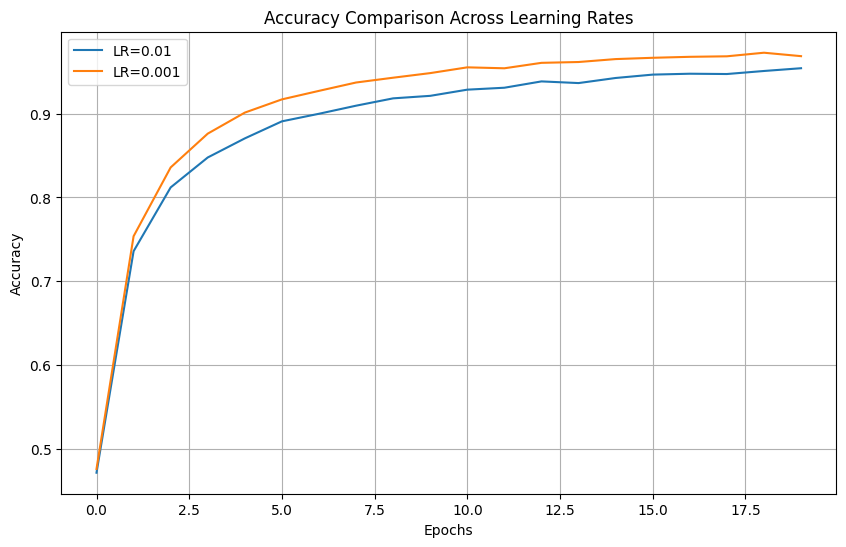

In [ ]:
# Plot the loss
plt.figure(figsize=(10, 6))
for lr, result in results_adam_lr.items():
    plt.plot(result["loss"], label=f"LR={lr}")

plt.title('Loss Comparison Across Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy
plt.figure(figsize=(10, 6))
for lr, result in results_adam_lr.items():
    plt.plot(result["accuracy"], label=f"LR={lr}")

plt.title('Accuracy Comparison Across Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

from this 2 graph we can see that 0.001 works best



so now we can train the training dataset and compare it against the validation dataset

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ASLCNN(num_classes=29).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

In [14]:

num_epochs = 20
train_loss_history, val_loss_history = [], []
train_accuracy_history, val_accuracy_history = [], []
val_f1_score_history, val_precision_history, val_recall_history = [], [], []

for epoch in range(num_epochs):
    # training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} (Training)", unit="batch")
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        # forward pass
        outputs = model(inputs)
        loss = loss_func(outputs, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        progress_bar.set_postfix(loss=(running_loss / len(train_loader)))

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)

    # validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} (Validation)", unit="batch")
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # forward pass
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    val_loss = val_running_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    val_loss_history.append(val_loss)
    val_accuracy_history.append(val_accuracy)
    cm = confusion_matrix(all_labels, all_predictions)

    # calculate F1score, precision, and recall
    val_f1 = f1_score(all_labels, all_predictions, average="macro")
    val_precision = precision_score(all_labels, all_predictions, average="macro", zero_division=0)
    val_recall = recall_score(all_labels, all_predictions, average="macro", zero_division=0)

    val_f1_score_history.append(val_f1)
    val_precision_history.append(val_precision)
    val_recall_history.append(val_recall)

    print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Train Accuracy = {train_accuracy:.4f}, "
          f"Val Loss = {val_loss:.4f}, Val Accuracy = {val_accuracy:.4f}, "
          f"Val F1 Score = {val_f1:.4f}, Val Precision = {val_precision:.4f}, Val Recall = {val_recall:.4f}")


Epoch 1/20 (Validation): 100%|██████████| 210/210 [00:32<00:00,  6.43batch/s]


Epoch 1: Train Loss = 0.9317, Train Accuracy = 0.7358, Val Loss = 0.6962, Val Accuracy = 0.8066, Val F1 Score = 0.8150, Val Precision = 0.8354, Val Recall = 0.8115


Epoch 2/20 (Validation): 100%|██████████| 210/210 [00:24<00:00,  8.55batch/s]


Epoch 2: Train Loss = 0.6041, Train Accuracy = 0.8261, Val Loss = 0.4567, Val Accuracy = 0.8763, Val F1 Score = 0.8797, Val Precision = 0.8898, Val Recall = 0.8785


Epoch 3/20 (Validation): 100%|██████████| 210/210 [00:25<00:00,  8.22batch/s]


Epoch 3: Train Loss = 0.4456, Train Accuracy = 0.8705, Val Loss = 0.3686, Val Accuracy = 0.9018, Val F1 Score = 0.9046, Val Precision = 0.9087, Val Recall = 0.9047


Epoch 4/20 (Validation): 100%|██████████| 210/210 [00:25<00:00,  8.34batch/s]


Epoch 4: Train Loss = 0.3501, Train Accuracy = 0.8998, Val Loss = 0.2864, Val Accuracy = 0.9268, Val F1 Score = 0.9297, Val Precision = 0.9336, Val Recall = 0.9285


Epoch 5/20 (Validation): 100%|██████████| 210/210 [00:24<00:00,  8.54batch/s]


Epoch 5: Train Loss = 0.2912, Train Accuracy = 0.9148, Val Loss = 0.2841, Val Accuracy = 0.9215, Val F1 Score = 0.9230, Val Precision = 0.9263, Val Recall = 0.9237


Epoch 6/20 (Validation): 100%|██████████| 210/210 [00:26<00:00,  8.06batch/s]


Epoch 6: Train Loss = 0.2539, Train Accuracy = 0.9242, Val Loss = 0.2383, Val Accuracy = 0.9326, Val F1 Score = 0.9348, Val Precision = 0.9381, Val Recall = 0.9347


Epoch 7/20 (Validation): 100%|██████████| 210/210 [00:27<00:00,  7.75batch/s]


Epoch 7: Train Loss = 0.2214, Train Accuracy = 0.9337, Val Loss = 0.2355, Val Accuracy = 0.9369, Val F1 Score = 0.9386, Val Precision = 0.9399, Val Recall = 0.9386


Epoch 8/20 (Validation): 100%|██████████| 210/210 [00:27<00:00,  7.65batch/s]


Epoch 8: Train Loss = 0.1918, Train Accuracy = 0.9421, Val Loss = 0.1790, Val Accuracy = 0.9538, Val F1 Score = 0.9550, Val Precision = 0.9554, Val Recall = 0.9552


Epoch 9/20 (Validation): 100%|██████████| 210/210 [00:27<00:00,  7.73batch/s]


Epoch 9: Train Loss = 0.1719, Train Accuracy = 0.9478, Val Loss = 0.1724, Val Accuracy = 0.9511, Val F1 Score = 0.9524, Val Precision = 0.9531, Val Recall = 0.9521


Epoch 10/20 (Validation): 100%|██████████| 210/210 [00:24<00:00,  8.59batch/s]


Epoch 10: Train Loss = 0.1620, Train Accuracy = 0.9512, Val Loss = 0.1579, Val Accuracy = 0.9561, Val F1 Score = 0.9573, Val Precision = 0.9581, Val Recall = 0.9572


Epoch 11/20 (Validation): 100%|██████████| 210/210 [00:26<00:00,  7.96batch/s]


Epoch 11: Train Loss = 0.1440, Train Accuracy = 0.9555, Val Loss = 0.1775, Val Accuracy = 0.9485, Val F1 Score = 0.9502, Val Precision = 0.9524, Val Recall = 0.9496


Epoch 12/20 (Validation): 100%|██████████| 210/210 [00:23<00:00,  8.99batch/s]


Epoch 12: Train Loss = 0.1389, Train Accuracy = 0.9567, Val Loss = 0.1522, Val Accuracy = 0.9596, Val F1 Score = 0.9606, Val Precision = 0.9613, Val Recall = 0.9605


Epoch 13/20 (Validation): 100%|██████████| 210/210 [00:25<00:00,  8.21batch/s]


Epoch 13: Train Loss = 0.1224, Train Accuracy = 0.9622, Val Loss = 0.1359, Val Accuracy = 0.9633, Val F1 Score = 0.9644, Val Precision = 0.9649, Val Recall = 0.9641


Epoch 14/20 (Validation): 100%|██████████| 210/210 [00:24<00:00,  8.50batch/s]


Epoch 14: Train Loss = 0.1136, Train Accuracy = 0.9646, Val Loss = 0.1437, Val Accuracy = 0.9597, Val F1 Score = 0.9610, Val Precision = 0.9618, Val Recall = 0.9608


Epoch 15/20 (Validation): 100%|██████████| 210/210 [00:25<00:00,  8.09batch/s]


Epoch 15: Train Loss = 0.1136, Train Accuracy = 0.9633, Val Loss = 0.1392, Val Accuracy = 0.9611, Val F1 Score = 0.9623, Val Precision = 0.9631, Val Recall = 0.9619


Epoch 16/20 (Validation): 100%|██████████| 210/210 [00:24<00:00,  8.46batch/s]


Epoch 16: Train Loss = 0.0987, Train Accuracy = 0.9692, Val Loss = 0.1366, Val Accuracy = 0.9649, Val F1 Score = 0.9662, Val Precision = 0.9672, Val Recall = 0.9659


Epoch 17/20 (Validation): 100%|██████████| 210/210 [00:25<00:00,  8.17batch/s]


Epoch 17: Train Loss = 0.1038, Train Accuracy = 0.9674, Val Loss = 0.1298, Val Accuracy = 0.9657, Val F1 Score = 0.9668, Val Precision = 0.9674, Val Recall = 0.9665


Epoch 18/20 (Validation): 100%|██████████| 210/210 [00:25<00:00,  8.31batch/s]


Epoch 18: Train Loss = 0.1018, Train Accuracy = 0.9671, Val Loss = 0.1229, Val Accuracy = 0.9687, Val F1 Score = 0.9697, Val Precision = 0.9701, Val Recall = 0.9696


Epoch 19/20 (Validation): 100%|██████████| 210/210 [00:23<00:00,  8.98batch/s]


Epoch 19: Train Loss = 0.0853, Train Accuracy = 0.9738, Val Loss = 0.1205, Val Accuracy = 0.9675, Val F1 Score = 0.9685, Val Precision = 0.9690, Val Recall = 0.9684


Epoch 20/20 (Validation): 100%|██████████| 210/210 [00:26<00:00,  7.91batch/s]


Epoch 20: Train Loss = 0.0795, Train Accuracy = 0.9752, Val Loss = 0.1341, Val Accuracy = 0.9645, Val F1 Score = 0.9654, Val Precision = 0.9658, Val Recall = 0.9654


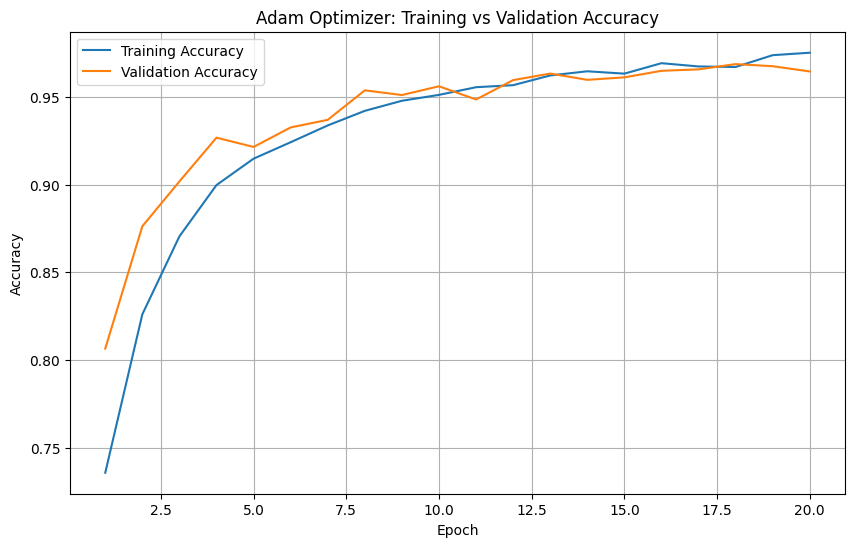

In [15]:
#training acc vs val acc
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracy_history, label="Training Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracy_history, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Adam Optimizer: Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

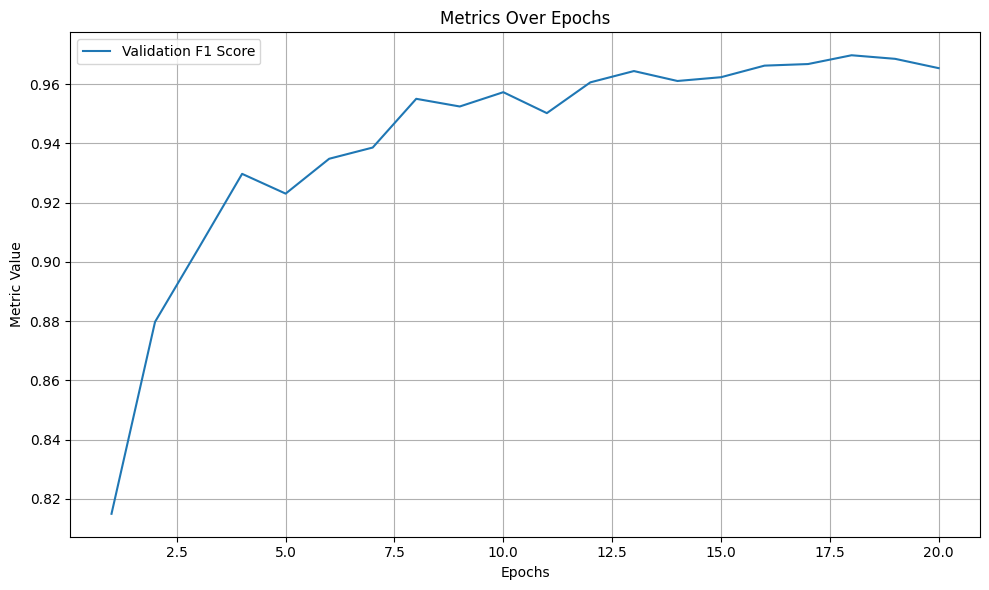

In [16]:
#plot F1score
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))

plt.plot(epochs, val_f1_score_history, label="Validation F1 Score")

plt.title("Metrics Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

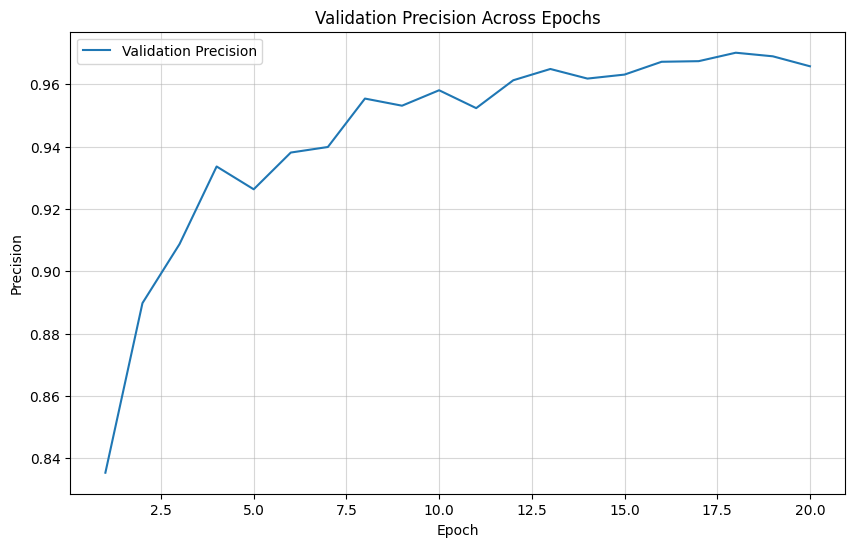

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), val_precision_history, label="Validation Precision")
plt.title("Validation Precision Across Epochs")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.grid(alpha=0.5)
plt.legend()
plt.show()

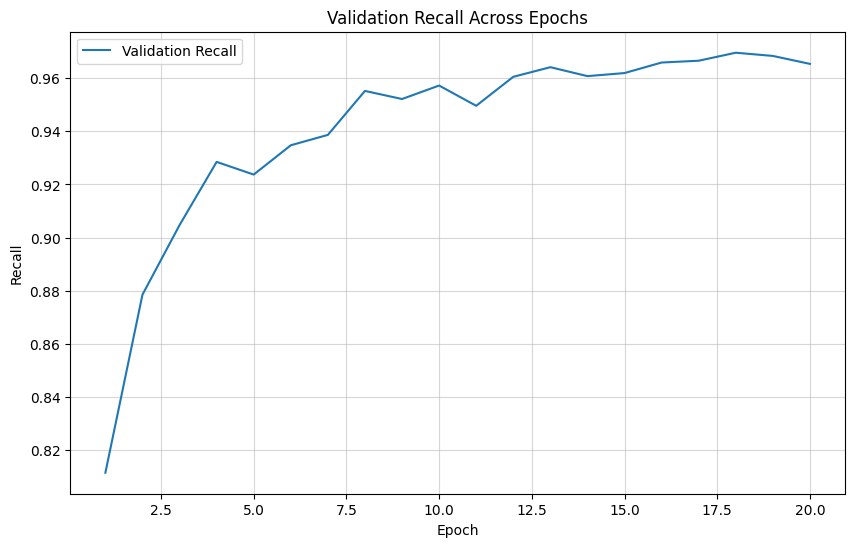

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), val_recall_history, label="Validation Recall")
plt.title("Validation Recall Across Epochs")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.grid(alpha=0.5)
plt.legend()
plt.show()

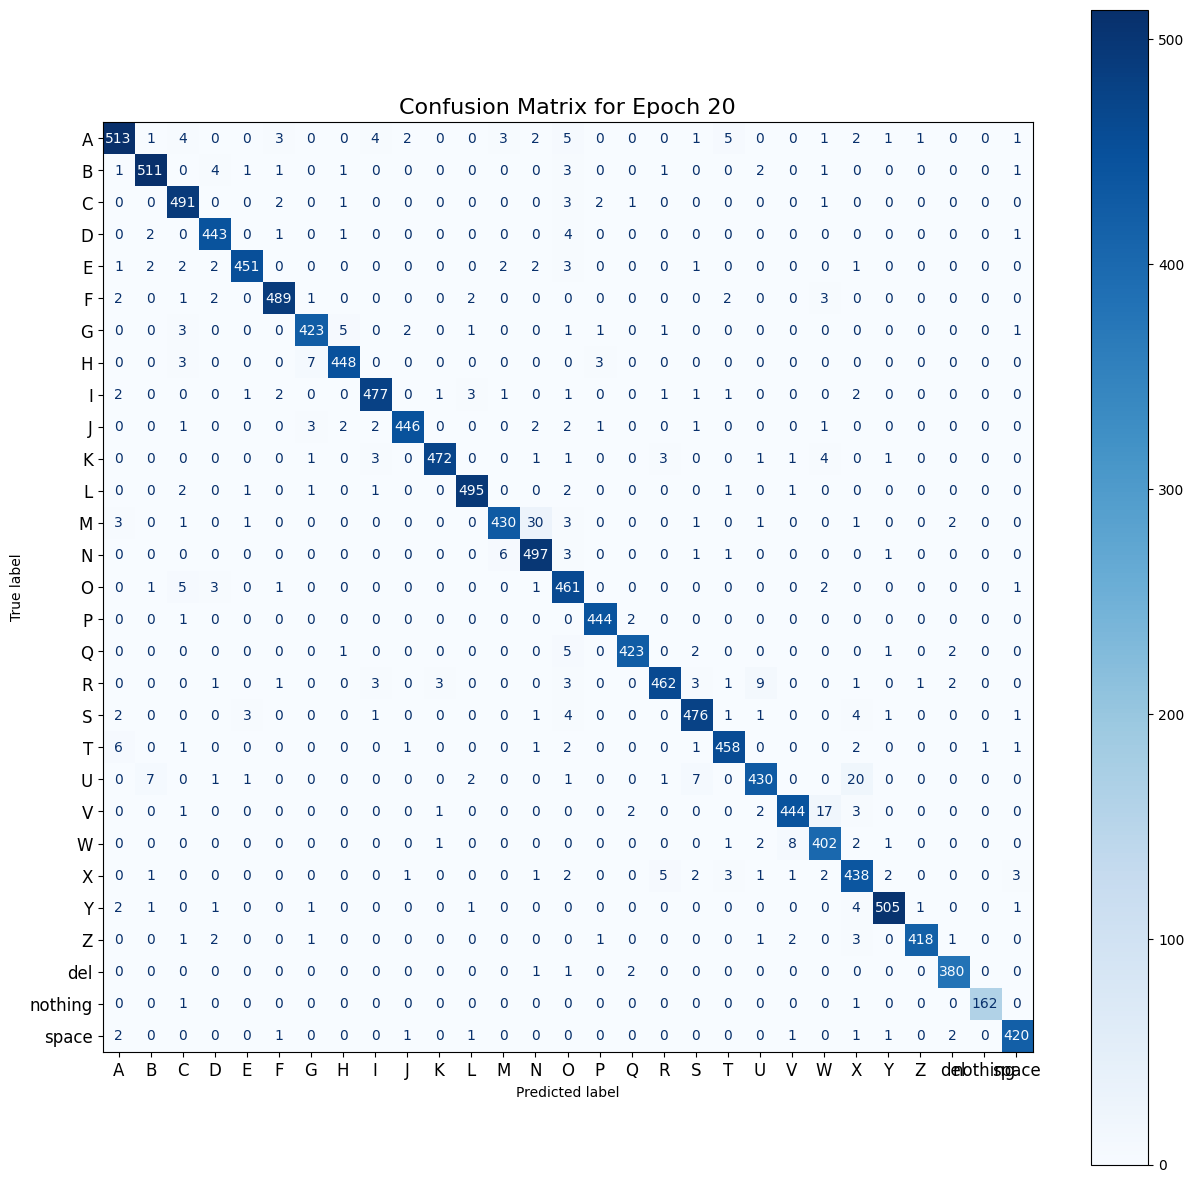

In [19]:
fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_loader.dataset.dataset.classes)
disp.plot(cmap='Blues', ax=ax)
plt.title(f"Confusion Matrix for Epoch {epoch + 1}", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
